In [1]:
# Import packages
import pathlib
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import pandas as pd
from skimage import exposure
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0 #MODEL B

### Data

In [2]:
train_dir = pathlib.Path('D:/University/CS3244/Project/EfficientNet/data - Copy/data(woodpecker_5_class)/train')
valid_dir = pathlib.Path('D:/University/CS3244/Project/EfficientNet/data - Copy/data(woodpecker_5_class)/valid')

In [3]:
# Set Image Dimension (determined by EfficientNet model choice)
IMG_SIZE = 224 # B0=224

# Set Batch Size
BATCH_SIZE = 64

# training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE)

# validation set
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    label_mode = 'categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 344 files belonging to 5 classes.
Found 43 files belonging to 5 classes.


In [4]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

for name in CLASS_NAMES:
    print(name)

Common Flameback
Coppersmith Barbet
Laced Woodpecker
Rufous Woodpecker
Sunda Pygmy Woodpecker


In [5]:
CLASS_NAMES

['Common Flameback',
 'Coppersmith Barbet',
 'Laced Woodpecker',
 'Rufous Woodpecker',
 'Sunda Pygmy Woodpecker']

### Model

In [5]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [6]:
model = build_model(num_classes=NUM_CLASSES)

In [7]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]'

 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_a

 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
          

                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_s

 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_a

                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  10368       ['block7a_expand_activation[0][0]
 D)       

### Training Stage 1

In [8]:
epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, 
                 epochs = epochs, 
                 validation_data = valid_ds,
                 verbose=2)

Epoch 1/25
6/6 - 31s - loss: 0.7715 - accuracy: 0.7500 - val_loss: 0.2575 - val_accuracy: 0.9535 - 31s/epoch - 5s/step
Epoch 2/25
6/6 - 18s - loss: 0.0326 - accuracy: 0.9913 - val_loss: 0.1788 - val_accuracy: 0.9302 - 18s/epoch - 3s/step
Epoch 3/25
6/6 - 21s - loss: 0.0515 - accuracy: 0.9797 - val_loss: 0.1938 - val_accuracy: 0.9535 - 21s/epoch - 4s/step
Epoch 4/25
6/6 - 20s - loss: 0.0107 - accuracy: 0.9942 - val_loss: 0.1893 - val_accuracy: 0.9302 - 20s/epoch - 3s/step
Epoch 5/25
6/6 - 21s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1574 - val_accuracy: 0.9302 - 21s/epoch - 4s/step
Epoch 6/25
6/6 - 21s - loss: 0.0105 - accuracy: 0.9971 - val_loss: 0.1142 - val_accuracy: 0.9535 - 21s/epoch - 3s/step
Epoch 7/25
6/6 - 21s - loss: 2.2813e-04 - accuracy: 1.0000 - val_loss: 0.0831 - val_accuracy: 0.9767 - 21s/epoch - 4s/step
Epoch 8/25
6/6 - 21s - loss: 1.2865e-04 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9767 - 21s/epoch - 3s/step
Epoch 9/25
6/6 - 16s - loss: 1.8721e-04 

In [9]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

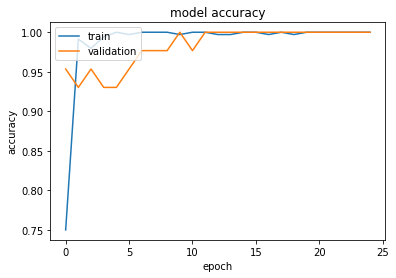

In [10]:
plot_hist(hist)

### Training Stage 2

In [11]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [12]:
unfreeze_model(model)

In [13]:
epochs = 10  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, 
                 epochs = epochs, 
                 validation_data = valid_ds,
                 verbose=2)

Epoch 1/10
6/6 - 47s - loss: 1.2423e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000 - 47s/epoch - 8s/step
Epoch 2/10
6/6 - 23s - loss: 1.5347e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000 - 23s/epoch - 4s/step
Epoch 3/10
6/6 - 22s - loss: 0.0063 - accuracy: 0.9942 - val_loss: 0.0013 - val_accuracy: 1.0000 - 22s/epoch - 4s/step
Epoch 4/10
6/6 - 23s - loss: 2.0221e-05 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000 - 23s/epoch - 4s/step
Epoch 5/10
6/6 - 22s - loss: 6.6986e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 - 22s/epoch - 4s/step
Epoch 6/10
6/6 - 22s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000 - 22s/epoch - 4s/step
Epoch 7/10
6/6 - 23s - loss: 1.0214e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000 - 23s/epoch - 4s/step
Epoch 8/10
6/6 - 21s - loss: 2.2730e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000 - 21s/epoch - 4s/step
Epoch 9/10
6/6 - 22s - l

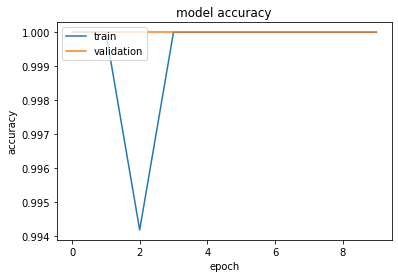

In [14]:
plot_hist(hist)

### Save Model

In [15]:
model.save('D:\\University\\CS3244\\Project\\EfficientNet\\saved_model\\model_B0MLwood5nad')

INFO:tensorflow:Assets written to: D:\University\CS3244\Project\EfficientNet\saved_model\model_B0MLwood5nad\assets


### Evaluation

In [16]:
test_dir = pathlib.Path('D:/University/CS3244/Project/EfficientNet/data - Copy/data(woodpecker_5_class)/test')

In [17]:
# Function to process and predict image
def image_prediction(image):
    # Process input image
    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = np.expand_dims(image_resized, axis=0)
    
    # Run image through model to obtain prediction
    pred = model.predict(image)
        # pred is a array of length class_count. Each entry is the probability for a particular class
        # Index based on class_names
    
    # Obtain prediction class
    pred_class = CLASS_NAMES[np.argmax(pred)]
    
    return pred_class

In [18]:
total_count   = [0] * NUM_CLASSES
correct_count = [0] * NUM_CLASSES
wrong_count   = [0] * NUM_CLASSES

for bird_folder in test_dir.rglob("*"):
    for bird_image in bird_folder.rglob("*.jpg"):
        
        bird_species = str(bird_folder.stem)
        bird_index = CLASS_NAMES.index(bird_species)
        
        # Update total count
        total_count[bird_index] += 1
        
        # Load image
        image = cv2.imread(str(bird_image))
        
        # Predict classification
        pred_class = image_prediction(image)
        # print(pred_class)
        
        if str(pred_class) == bird_species:
            correct_count[bird_index] += 1
        else:
            wrong_count[bird_index] += 1  

In [19]:
results = pd.DataFrame({'Class': CLASS_NAMES,
                        'actual_count' : total_count,
                        'correct_count' : correct_count,
                        'wrong_count' : wrong_count})

results['Precision'] = results['correct_count']/(results['correct_count']+results['wrong_count'])
results['Recall'] = results['correct_count']/(results['actual_count'])
results['F1 Score'] = (2/((1/results['Precision'])+(1/results['Recall'])))

In [20]:
results

,Class,actual_count,correct_count,wrong_count,Precision,Recall,F1 Score
0,Common Flameback,9,8,1,0.888889,0.888889,0.888889
1,Coppersmith Barbet,8,8,0,1.000000,1.000000,1.000000
2,Laced Woodpecker,9,6,3,0.666667,0.666667,0.666667
3,Rufous Woodpecker,9,9,0,1.000000,1.000000,1.000000
4,Sunda Pygmy Woodpecker,8,8,0,1.000000,1.000000,1.000000


In [21]:
weighted_F1_score = (sum(results['F1 Score']*results['actual_count'])/sum(results['actual_count']))*100
weighted_precision = (sum(results['Precision']*results['actual_count'])/sum(results['actual_count']))*100
weighted_recall = (sum(results['Recall']*results['actual_count'])/sum(results['actual_count']))*100

print('Weighted F1 Score: '+str(weighted_F1_score)+'%')
print('Weighted Precision: '+str(weighted_precision)+'%')
print('Weighted Recall: '+str(weighted_recall)+'%')

Weighted F1 Score: 90.69767441860465%
Weighted Precision: 90.69767441860465%
Weighted Recall: 90.69767441860465%


In [22]:
mAP = sum(results['Precision'])/NUM_CLASSES
mAP*100

91.11111111111111